In [41]:
import streamlit as st
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
import cv2
import os
from streamlit_cropper import st_cropper
from PIL import Image
NUMEXPR_MAX_THREADS=16

from matplotlib import pyplot as plt

# https://stackoverflow.com/questions/14134892/convert-image-from-pil-to-opencv-format
# pil_image = PIL.Image.open('Image.jpg').convert('RGB') 
# open_cv_image = numpy.array(pil_image) 
# # Convert RGB to BGR 
# open_cv_image = open_cv_image[:, :, ::-1].copy() 

8.2.0


[[[188 191 196]
  [189 192 197]
  [189 192 197]
  ...
  [189 199 208]
  [190 200 209]
  [190 200 209]]

 [[187 190 195]
  [188 191 196]
  [188 191 196]
  ...
  [191 200 209]
  [192 201 210]
  [195 204 213]]

 [[187 190 195]
  [189 192 197]
  [188 191 196]
  ...
  [191 200 207]
  [192 201 208]
  [194 203 210]]

 ...

 [[225 226 208]
  [225 226 208]
  [225 226 208]
  ...
  [119 132 140]
  [ 24  37  45]
  [114 121 129]]

 [[227 226 208]
  [227 226 208]
  [227 226 208]
  ...
  [133 144 150]
  [ 41  52  58]
  [ 32  39  47]]

 [[227 226 208]
  [227 226 208]
  [227 226 208]
  ...
  [104 113 118]
  [ 98 107 112]
  [ 34  41  49]]]


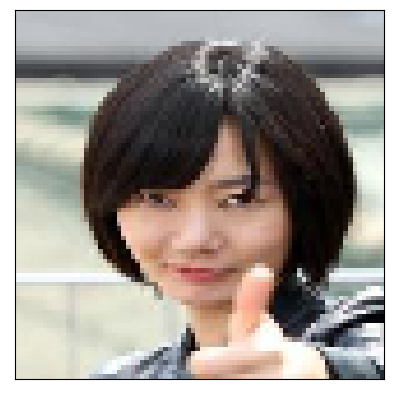

In [266]:
def show_img(img):
    plt.imshow(img), plt.xticks([]), plt.yticks([])
    plt.show()

In [ ]:
# https://towardsdatascience.com/face-detection-in-2-minutes-using-opencv-python-90f89d7c0f81
def get_heads(img):
    heads = []
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_alt.xml')
    # Convert into grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Detect faces
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    # Draw rectangle around the faces
    for (x, y, w, h) in faces:
        size = 0
        if (w > h):
            size = w
        else:
            size = h
        newx = int(x-(w*0.1))
        neww = int(w*1.2)
        newy = int(y-(h*0.3))
        newh = int(h*1.4)
#         cv2.rectangle(img, (newx, newy), (newx+neww, newy+newh), (255, 0, 0), 2)
#         cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
        heads.append(img[
            int(newy):int(newy+newh),
            int(newx):int(newx+neww) 
        ])
    return heads

In [ ]:
# https://docs.streamlit.io/library/advanced-features/session-state
if 'img' not in st.session_state:
    st.session_state.img = []
    
if 'heads' not in st.session_state:
    st.session_state.heads = []
    
if 'headsbool' not in st.session_state:
    st.session_state.headsbool = []

In [ ]:
progress = st.sidebar.radio("Progress",('Upload Image', 'Process Image', 'Result'))

In [ ]:
if(progress == 'Upload Image'):
    st.title("Upload Image")
    uploadmethod = st.radio("Way to upload",('Upload Image', 'With Camera'))
    if(uploadmethod == 'Upload Image'):
        file = st.file_uploader(label='Upload file', type=['png', 'jpg'])
        if (file):
            image = Image.open(file)
            img_array = np.array(image)
            st.session_state.img = img_array
        
    if(uploadmethod == 'With Camera'):
        run = True
        placeholder = st.empty()
        FRAME_WINDOW = st.image([])
        camera = cv2.VideoCapture(0)

        frame = camera.read()
        if placeholder.button('Take Picture'):
            st.session_state.img = cv2.cvtColor(frame[1], cv2.COLOR_BGR2RGB)
            placeholder.empty()
            run = False
        while run:
            _, frame = camera.read()
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            FRAME_WINDOW.image(frame)
        if (len(img) != 0):
            retakebtn = st.button("Retake")
            if retakebtn:
                run =True
                st.session_state.img = []

    if (len(st.session_state.img) != 0):
        st.write("Click “Process Image” radio button on the side bar when the image is uploaded")
        st.image(st.session_state.img)
        
        st.session_state.heads = get_heads(st.session_state.img)
        for i in range(len(get_heads(st.session_state.img))):
            st.session_state.headsbool.append(True)

In [ ]:
if(progress == 'Process Image'):
    st.title("Process Image")
    if (len(st.session_state.img) == 0):
        st.error('No Image choosed')
    else:
        st.write("Number of face detected:", len(st.session_state.heads))
        st.write("detected face have been load to choosed image")
        
        box_color = st.color_picker(label="Box Color", value='#0000FF')
        img = Image.fromarray(st.session_state.img)
        # Get a cropped image from the frontend
        cropped_img = st_cropper(img, realtime_update=True, box_color=box_color,
                                    aspect_ratio=(1,1))
        savebtn = st.button("save")
        if savebtn:
            st.session_state.heads.append(cv2.cvtColor(np.array(cropped_img)[:, :, ::-1].copy(), cv2.COLOR_RGB2BGR))
            st.session_state.headsbool.append(True)
        # Manipulate cropped image at will
        st.header("Preview")
        _ = cropped_img.thumbnail((150,150))
        st.image(cropped_img)
        
        st.header("Choosed head")
        for i in range(len(st.session_state.heads)):
            if (st.session_state.headsbool[i] == True):
                placeholder = st.empty()
                col1, col2, col3 = placeholder.columns(3)
                with col1:
                    st.image(st.session_state.heads[i])
                with col2:
                    if st.button("Delete",key = "Delete_"+str(i)):
                        placeholder.empty()
                        st.session_state.headsbool[i] = False

In [29]:
if(progress == 'Result'):
    st.title("Result")
    if (len(st.session_state.img) == 0):
        st.error('No Image choosed')
    if (np.count_nonzero(st.session_state.headsbool) == 0):
        st.error('Picture not processed and cannot detect face by CascadeClassifier')
    else:
        st.image(st.session_state.img)
        os.path.exists('./model/AgeDetection/Freeze/AgePrediction.h5')
        age_model = tf.keras.models.load_model('./model/AgeDetection/Freeze/Freeze_BestModelAge.h5')
        labels_age = {0: 'Adolescence', 1: 'Adult',2:'Child',3:'Senior Citizen'}
        gender_model = tf.keras.models.load_model('./model/GenderDetection/Freeze/GenderPrediction.h5')
        labels_gender = {0: 'Female', 1: 'Male'}
        for i in range(len(st.session_state.heads)):
            if (st.session_state.headsbool[i] == True):
                col1, col2 = st.columns([1, 2])
                img = st.session_state.heads[i]
                img = img/255
                resized = cv2.resize(img, (80,80))
                reshaped = resized.reshape(1,80, 80,3)
                
                predictions = age_model.predict(reshaped)
                predicted_class = np.argmax(predictions,axis=1).item(0)
                age_predicted_label = labels_age[predicted_class]
                age_df = pd.DataFrame(predictions, columns=[labels_age[key] for key in labels_age])
                
                predictions = gender_model.predict(reshaped)
                predicted_class = np.argmax(predictions,axis=1).item(0)
                gender_predicted_label = labels_gender[predicted_class]
                gender_df = pd.DataFrame(predictions, columns=[labels_gender[key] for key in labels_gender])
                with col1:
                    st.image(st.session_state.heads[i])
                with col2:
#                     st.write(age_predicted_label)
                    with st.expander(age_predicted_label):
                        st.write(age_df)
                    with st.expander(gender_predicted_label):
                        st.write(gender_df)
#                     st.write(gender_predicted_label)

NameError: name 'progress' is not defined

In [31]:
# before use streamlit:
# conda install -c conda-forge nbconvert
# run this cell (for convert ipynb to py)
    # run this cmd in anaconda powershell prompt streamlit run .\Main.py (remember change path to this file's location)
!jupyter nbconvert Main.ipynb --to script --TagRemovePreprocessor.enabled=True --ClearMetadataPreprocessor.enabled=True -TagRemovePreprocessor.remove_cell_tags='{"remove_cell"}'

# !heroku create
# git init
# git add .
# git commit -m "initial commit"
# heroku create
# git push heroku master

C:\Users\wangl\anaconda3\lib\site-packages\traitlets\traitlets.py:2196: FutureWarning: Supporting extra quotes around Unicode is deprecated in traitlets 5.0. Use 'remove_cell' instead of "'remove_cell'" – or use CUnicode.
  warn(
[NbConvertApp] Converting notebook Main.ipynb to script
[NbConvertApp] Writing 7145 bytes to Main.py
